In [7]:
import numpy as np
import scipy.stats as stats
import spectral_embedding as se
import matplotlib as mpl
import matplotlib.pyplot as plt

### One-step functions

In [8]:
def onestep(XA, A):
    n, d = XA.shape
    X1 = np.zeros((n,d))
    
    for i in range(n):
        M1 = np.zeros((d,d))
        M2 = np.zeros(d)
        for j in range(n):
            pij = XA[i].T @ XA[j]
            M1 += np.outer(XA[j], XA[j]) / (pij*(1-pij))
            M2 += (A[i,j]-pij)*XA[j] / (pij*(1-pij))
        X1[i] = XA[i] + np.linalg.inv(M1/n) @ (M2/n)
    
    return X1

In [9]:
def onestep_G(B, pi):
    K = len(pi)
    UB, SB, VBt = np.linalg.svd(B)
    
    # Find effective embedding dimension by ignoring (nearly) zero eigenvalues
    d = np.sum(SB > 1e-10)
    XB = UB[:,0:d] @ np.diag(np.sqrt(SB[0:d]))
    
    G = np.zeros((K,d,d))
    for i in range(K):
        for j in range(K):
            G[i] += pi[j]*np.outer(XB[j],XB[j]) / (B[i,j]*(1-B[i,j]))
            
    return G

In [10]:
def W_transform(A, B, Z):
    P = B[Z,:][:,Z]
            
    # Spectral embeddings
    UA, SA, VAt = np.linalg.svd(A); VA = VAt.T
    UB, SB, VBt = np.linalg.svd(B); VB = VBt.T
    UP, SP, VPt = np.linalg.svd(P); VP = VPt.T

    # Find effective embedding dimension by ignoring (nearly) zero eigenvalues
    d = np.sum(SB > 1e-10)
    
    XB = UB[:,0:d] @ np.diag(np.sqrt(SB[0:d]))
    XP = UP[:,0:d] @ np.diag(np.sqrt(SP[0:d]))
    XZ = XB[Z,:]
    
    # Find spectral embedding map to latent positions
    UW, _, VWt = np.linalg.svd(UP[:,0:d].T @ UA[:,0:d] + VP[:,0:d].T @ VA[:,0:d])
    W = UW @ VWt
    L = np.linalg.inv(XZ.T @ XZ) @ XZ.T @ XP
   
    return L @ W

### Two-community SBM with two positive eigenvalues

In [11]:
np.random.seed(42)

The first step is to compute the adjacency spectral embedding of the network, which we use as the initialisation for the one-step update. In this example, we assume that the block mean matrix $\mathbf{B}$ for the two-community stochastic block model was the following form:
$$ \mathbf{B} = \left( \begin{array}{cc}
        p & q \\
        q & p
    \end{array} \right),
$$
where $p > q$, so that the matrix is positive definite. Since, we know the asymptotic distribution for the embedding, we may as well compute the mean and covariance terms for the central limit theorem.

In [12]:
K = 2
n = 1000
pi = np.repeat(1/K, K)

p = 0.3; q = 0.2
B = np.array([[p, q],
              [q, p]])
print(B)

[[0.3 0.2]
 [0.2 0.3]]


In [13]:
A, Z = se.generate_SBM(n, B, pi)
Zcol = [[(1.0,0.0,0.0),(0.0,0.0,1.0)][z] for z in Z]

In [14]:
XA = se.ASE(A, K)
X, SigmaX = se.SBM_distbn(A, B, Z, pi, K)

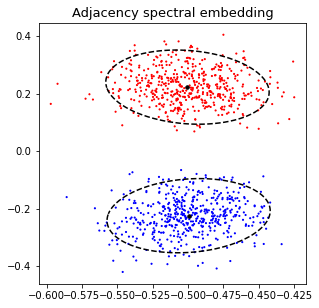

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4.8,4.8))

ax.scatter(XA[:,0], XA[:,1], marker='.', s=5, c=Zcol)
ax.scatter(X[:,0], X[:,1], marker='o', s=12, c='black')
ax.set_title('Adjacency spectral embedding', fontsize=13)

for i in range(K):
    ellipse = se.gaussian_ellipse(X[i], SigmaX[i][0:2,0:2]/n)
    ax.plot(ellipse[0],ellipse[1],'--', color='black')
    
# Save limits for later use
xlim = ax.get_xlim()
ylim = ax.get_ylim();

In [16]:
print('Chernoff information:', np.round(se.chernoff(X, SigmaX), 5))

Chernoff information: 0.00676


Now, let's consider the one-step embedding and it's asymptotic distribution. The update of every latent position is a little slow, so I wouldn't recommend using this approach on large networks.

In [17]:
X1 = onestep(XA, A)
G = onestep_G(B, pi)

Rotate the theoretical covariance terms for the one-step embedding by the $\textbf{W}$ tranformation that also appears in the adjacency spectral embedding.

In [18]:
W = W_transform(A, B, Z)

SigmaG = np.zeros(G.shape)
for i in range(K):
    SigmaG[i] = W.T @ np.linalg.inv(G[i]) @ W

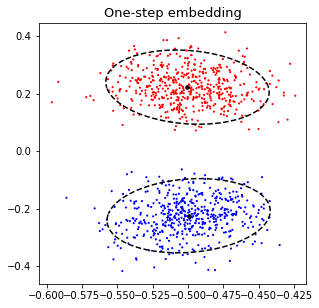

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4.8,4.8))

ax.scatter(X1[:,0], X1[:,1], marker='.', s=5, c=Zcol)
ax.scatter(X[:,0], X[:,1], marker='o', s=12, c='black')
ax.set_title('One-step embedding', fontsize=13)

for i in range(K):
    ellipse = se.gaussian_ellipse(X[i], SigmaG[i][0:2,0:2]/n)
    ax.plot(ellipse[0],ellipse[1],'--', color='black')
    
# Use previous limits as we often get extreme one-step embedding values
ax.set_xlim(xlim)
ax.set_ylim(ylim);

In [20]:
print('Chernoff information:', np.round(se.chernoff(X, SigmaG), 5))

Chernoff information: 0.00676


In this case, the covariance matrices $\mathbf{\Sigma}(x)$ for the adjacency spectral embedding, and $\mathbf{G}(x)^{-1}$ for the one-step embedding are the same. 

In [21]:
SigmaX

array([[[ 0.74081717, -0.22895014],
        [-0.22895014,  3.69918283]],

       [[ 0.73920213,  0.21826054],
        [ 0.21826054,  3.70079787]]])

In [22]:
SigmaG

array([[[ 0.74081717, -0.22895014],
        [-0.22895014,  3.69918283]],

       [[ 0.73920213,  0.21826054],
        [ 0.21826054,  3.70079787]]])

### Two-community SBM with rank one

In [23]:
np.random.seed(42)

In [24]:
K = 2
n = 1000
pi = np.repeat(1/K, K)

p = 0.6; q = 0.2
B = np.array([[p],[q]]) @ np.array([[p],[q]]).T
print(B)

[[0.36 0.12]
 [0.12 0.04]]


In [25]:
A, Z = se.generate_SBM(n, B, pi)
Zcol = [[(1.0,0.0,0.0),(0.0,0.0,1.0)][z] for z in Z]

In [26]:
XA = se.ASE(A, 1)
X, SigmaX = se.SBM_distbn(A, B, Z, pi, 1)

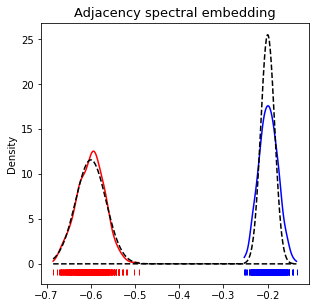

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4.8,4.8))

x0 = np.arange(np.min(XA[Z == 0]), np.max(XA[Z == 0]), 0.001)
x1 = np.arange(np.min(XA[Z == 1]), np.max(XA[Z == 1]), 0.001)
x = np.arange(np.min(XA), np.max(XA), 0.001)

density_red = stats.kde.gaussian_kde((XA[Z == 0]).reshape(-1))
ax.plot(x0, density_red(x0), '-', color='red')
ax.plot(x, stats.norm.pdf(x, X[0], SigmaX[0]/np.sqrt(n)).reshape(-1), '--', color='black')
ax.plot((XA[Z == 0]).reshape(-1), [-0.9]*len((XA[Z == 0]).reshape(-1)), '|', c='red')

density_blue = stats.kde.gaussian_kde((XA[Z == 1]).reshape(-1))
ax.plot(x1, density_blue(x1), '-', color='blue')
ax.plot(x, stats.norm.pdf(x, X[1], SigmaX[1]/np.sqrt(n)).reshape(-1), '--', color='black')
ax.plot((XA[Z == 1]).reshape(-1), [-0.9]*len((XA[Z == 1]).reshape(-1)), '|', c='blue')

ax.set_title('Adjacency spectral embedding', fontsize=13)
ax.set_ylabel('Density');

In [28]:
print('Chernoff information:', np.round(se.chernoff(X, SigmaX), 5))

Chernoff information: 0.02621


In [29]:
X1 = onestep(XA, A)
G = onestep_G(B, pi)

In [30]:
W = W_transform(A, B, Z)

SigmaG = np.zeros(G.shape)
for i in range(K):
    SigmaG[i] = W.T @ np.linalg.inv(G[i]) @ W

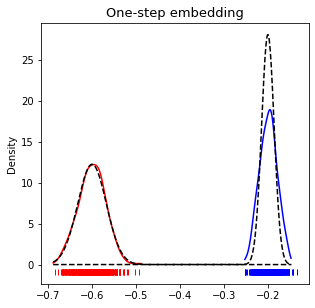

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4.8,4.8))

x0 = np.arange(np.min(X1[Z == 0]), np.max(X1[Z == 0]), 0.001)
x1 = np.arange(np.min(X1[Z == 1]), np.max(X1[Z == 1]), 0.001)
x = np.arange(np.min(X1), np.max(X1), 0.001)

density_red = stats.kde.gaussian_kde((X1[Z == 0]).reshape(-1))
ax.plot(x0, density_red(x0), '-', color='red')
ax.plot(x, stats.norm.pdf(x, X[0], SigmaG[0]/np.sqrt(n)).reshape(-1), '--', color='black')
ax.plot((XA[Z == 0]).reshape(-1), [-0.9]*len((XA[Z == 0]).reshape(-1)), '|', c='red')

density_blue = stats.kde.gaussian_kde((X1[Z == 1]).reshape(-1))
ax.plot(x1, density_blue(x1), '-', color='blue')
ax.plot(x, stats.norm.pdf(x, X[1], SigmaG[1]/np.sqrt(n)).reshape(-1), '--', color='black')
ax.plot((XA[Z == 1]).reshape(-1), [-0.9]*len((XA[Z == 1]).reshape(-1)), '|', c='blue')

ax.set_title('One-step embedding', fontsize=13)
ax.set_ylabel('Density');

In both cases, the observed embedding distribution is some way off the asymptotic distributions given by the central limit theorems, particularly for community 2 shown in blue. This may be an artefact of the rank one structure we imposed on the stochastic block model. However, in this example, the covariances $\mathbf{\Sigma}(x)$ for adjacency spectral embedding are larger than the covariances $\mathbf{G}(x)^{-1}$ for the one-step embedding.

In [32]:
SigmaX

array([[[1.0896]],

       [[0.4944]]])

In [33]:
SigmaG

array([[[1.0302439]],

       [[0.4493617]]])